AMUSE tutorial on high-order bridge
====================

Hierarchical coupling strategies are fundamental parts of AMUSE.
It enables us to combined the output of a wide variety of solvers into a homogeneous solution.
In this example we will be nesting multiple bridges, to show the power of bridge.

In [17]:
import numpy
from amuse.units import (units, constants)
#from amuse.lab import Particles

In [18]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary

def get_star_planet_and_moon():
    Mstar = 1.0|units.MSun
    Mplanet = 1.0|units.MJupiter
    a_planet = 5.2 | units.au
    e_planet = 0.0
    bodies = new_binary_from_orbital_elements(Mstar, Mplanet, a_planet, e_planet,
                                             G=constants.G)
    bodies[0].name = "star"
    bodies[1].name = "planet"
    planet = bodies[bodies.name=="planet"]
    RH_planet = a_planet*(1.0-e_planet)*(Mplanet/(3*Mstar))**(1./3.)
    a_moon = 0.1*RH_planet
    e_moon = 0.0
    Mmoon = 0.01*Mplanet
    Pmoon = orbital_period(Mplanet+Mmoon, a_moon)
    moon = new_binary_from_orbital_elements(planet.mass, 
                                            Mmoon, a_moon, e_moon,
                                            G=constants.G)
    moon.position -= moon[0].position
    moon.velocity -= moon[0].velocity
    moon = moon[1].as_set()
    moon.position += planet.position
    moon.velocity += planet.velocity
    moon.semimajor_axis = a_moon
    moon.name = "moon"
    bodies.add_particle(moon)
    bodies.move_to_center()
    return bodies
bodies = get_star_planet_and_moon()
print(bodies)

                 key         mass         name  semimajor_axis           vx           vy           vz            x            y            z
                   -         MSun         none  149597870691.0 * m  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  149597870691.0 * m  149597870691.0 * m  149597870691.0 * m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
11992421139574210381    1.000e+00         star    0.000e+00    0.000e+00   -3.465e-09   -0.000e+00   -5.009e-03   -0.000e+00   -0.000e+00
 5326756165488562113    9.546e-04       planet    0.000e+00    0.000e+00    3.581e-06    0.000e+00    5.195e+00    0.000e+00    0.000e+00
10820997325257666469    9.546e-06         moon    3.550e-02    0.000e+00    4.927e-06    0.000e+00    5.230e+00    0.000e+00    0.000e+00
====================  ===========  ===========  ===========  ===========  ==========

Now we have the orbits of the three particles, star, planet and moon. We now want to make a disk around the moon.

In [19]:
from amuse.ext.protodisk import ProtoPlanetaryDisk

from amuse.lab import nbody_system


def make_disk_around_celestial_body(moon, Mplanet):

    R = 1|units.au
    a_moon = moon.semimajor_axis
    e_moon = 0.0
    Mmoon = moon.mass.sum()
    RH_moon = a_moon*(1.0-e_moon)*(Mmoon/(3*Mplanet))**(1./3.)
    converter = nbody_system.nbody_to_si(Mmoon, R)
    Ndisk = 1000
    Rin = 0.03*RH_moon
    Rout = 0.3*RH_moon
    Pinner = orbital_period(Mmoon, Rin)
    Mdisk = 0.01 * Mmoon

    disk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter,
                              Rmin=Rin/R,
                              Rmax=Rout/R,
                              q_out=10.0,
                              discfraction=Mdisk/Mmoon).result
    disk.name = "disk "
    disk.move_to_center()
    disk.position += moon.position
    disk.velocity += moon.velocity

    masses = Mdisk/float(Ndisk)
    disk.mass = masses
    rho = 3.0| (units.g/units.cm**3)
    disk.radius = (disk.mass/(4*rho))**(1./3.)
    return disk, Pinner, converter

planet = bodies[bodies.name=="planet"]
moon = bodies[bodies.name=="moon"]
disk, Pinner, converter = make_disk_around_celestial_body(moon, 
                                               planet.mass.sum())

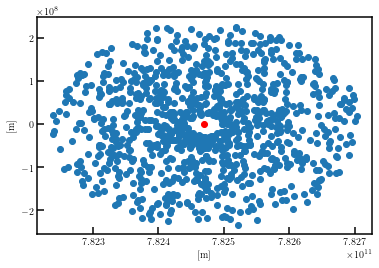

In [20]:
from amuse.plot import scatter
def plot(moon, disk):
    scatter(disk.x, disk.y)
    scatter(moon.x, moon.y, c='r')
plot(moon, disk)

In [21]:
from amuse.community.huayno.interface import Huayno
from amuse.community.fi.interface import Fi
gravity = Huayno(converter)
gravity.particles.add_particles(bodies-moon)
channel = {"from stars": bodies.new_channel_to(gravity.particles),
            "to_stars": gravity.particles.new_channel_to(bodies)}

hydro = Fi(converter, mode="openmp")
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 0.01*Pinner 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 0.1 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

hydro.particles.add_particles(disk)
hydro.dm_particles.add_particles(moon.as_set())
channel.update({"from_disk": disk.new_channel_to(hydro.particles)})
channel.update({"to_disk": hydro.particles.new_channel_to(disk)})
channel.update({"from_moon": moon.new_channel_to(hydro.dm_particles)})
channel.update({"to_moon": hydro.dm_particles.new_channel_to(moon)})

bodies.add_particles(disk)

In [22]:
from amuse.couple import bridge
from amuse.ext.composition_methods import *
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravity, (hydro,))
gravhydro.add_system(hydro, (gravity,))
gravhydro.timestep = 0.2*Pinner

In [23]:
from amuse.ext.composition_methods import *
from amuse.ext.orbital_elements import orbital_elements_from_binary

def gravity_hydro_bridge(gravity, hydro, gravhydro, bodies,
                         t_end):

    gravity_initial_total_energy = gravity.get_total_energy() + hydro.get_total_energy()
    model_time = 0 | units.Myr
    dt = 0.012|units.yr  #1.0*Pinner
    while model_time < t_end:

        model_time += dt

        orbit_planet = orbital_elements_from_binary(bodies[:2], G=constants.G)
        orbit_moon = orbital_elements_from_binary(bodies[1:3], G=constants.G)
        print("Planet:", "ae=", orbit_planet[2].in_(units.AU), orbit_planet[3])
        print("Moon:", "ae=", orbit_moon[2].in_(units.AU), orbit_moon[3])
        
        dE_gravity = gravity_initial_total_energy/(gravity.get_total_energy()+hydro.get_total_energy())
        print("Time:", model_time.in_(units.day), \
              "dE=", dE_gravity)#, dE_hydro

        gravhydro.evolve_model(model_time)
        channel["to_stars"].copy()
        channel["to_disk"].copy()
        channel["to_moon"].copy()
        
        print("S=", bodies[:3])
        print("g=", gravity.particles)
        print(gravity.particles.y.in_(units.au), moon.y.in_(units.au))

    gravity.stop()
    hydro.stop()

t_end = 1.0 | units.yr
gravity_hydro_bridge(gravity, hydro, gravhydro, 
                     bodies, t_end)

Planet: ae= 5.2 AU 1.05367121277e-08
Moon: ae= 0.0355011649073 AU 0.0
Time: 4.382906388 day dE= 1.0
S=                  key         mass         name       radius  semimajor_axis            u           vx           vy           vz            x            y            z
                   -         MSun         none  (0.001 * m**3)**0.3333333333333333  149597870691.0 * m  m**2 * s**-2  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  149597870691.0 * m  149597870691.0 * m  149597870691.0 * m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
11992421139574210381    1.000e+00         star    0.000e+00    0.000e+00    0.000e+00    2.187e-11   -3.465e-09   -2.847e-22   -5.009e-03   -3.185e-05   -6.218e-19
 5326756165488562113    9.546e-04       planet    0.000e+00    0.000e+00    0.000e+00   -1.809e-08    3.582e-06   -7.995e-16    5

Exception ignored in: <function CodeInterface.__del__ at 0x7f4ceb284f80>
Traceback (most recent call last):
  File "/home/spz/AMUSE/amuse/src/amuse/rfi/core.py", line 755, in __del__
    self._stop()
  File "/home/spz/AMUSE/amuse/src/amuse/rfi/core.py", line 845, in _stop
    self._stop_worker()
  File "/home/spz/AMUSE/amuse/src/amuse/rfi/core.py", line 123, in __call__
    raise exceptions.CodeException("Exception when calling function '{0}', of code '{1}', exception was '{2}'".format(self.specification.name, type(self.interface).__name__, ex))
amuse.support.exceptions.CodeException: Exception when calling function '_stop_worker', of code 'HuaynoInterface', exception was '[Errno 32] Broken pipe'
Exception ignored in: <function CodeInterface.__del__ at 0x7f4ceb284f80>
Traceback (most recent call last):
  File "/home/spz/AMUSE/amuse/src/amuse/rfi/core.py", line 755, in __del__
    self._stop()
  File "/home/spz/AMUSE/amuse/src/amuse/rfi/core.py", line 845, in _stop
    self._stop_worker

S=                  key         mass         name       radius  semimajor_axis            u           vx           vy           vz            x            y            z
                   -         MSun         none  (0.001 * m**3)**0.3333333333333333  149597870691.0 * m  m**2 * s**-2  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  3646245880.3572216 * m * s**-1  149597870691.0 * m  149597870691.0 * m  149597870691.0 * m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
11992421139574210381    1.000e+00         star    0.000e+00    0.000e+00    0.000e+00    1.098e-10   -3.464e-09   -8.781e-21   -5.007e-03   -1.599e-04   -1.349e-16
 5326756165488562113    9.546e-04       planet    0.000e+00    0.000e+00    0.000e+00   -1.006e-07    3.595e-06   -2.105e-14    5.193e+00    1.655e-01   -3.587e-10
10820997325257666469    9.546e-06         moon    2.175e+08    3.

KeyboardInterrupt: 

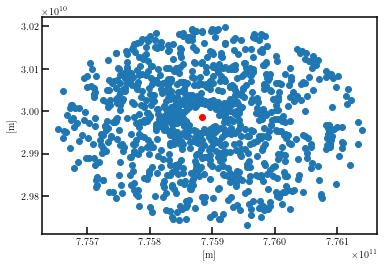

In [24]:
plot(moon, disk)

You have adopted the star-planet-moon system with disk. Instead of hyrarchical_bridge.py where the disk was integrated using a direct N-body code, the disk is now a gaseous.


Assignmnets and questions:
---------------

### Assignment 1:


### Question 1:
